In [1]:
# This script looks at the best and worst hours to travel across Snoqualmie Pass (WA) 
# by day of year. At first, we'll only look at traveling Westbound, but the script 
# can be easily adapted to look at both.
#
# Do the busiest hours of the day change throughout the year?
# The answer is yes, and...no. During the summer, more vehicles travel across the 
# pass over a greater portion of the day, but on average the vehicles are moving 
# at a faster speed.

%matplotlib inline
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats
import weatherlib

# Traffic sites
road_sites = ['S901','R039W','S903','B04']

In [2]:
# Get and process data

# Get data for all sites
road_vehicle, road_speed, road_count = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for site in road_sites:
    road_vehicle = road_vehicle.append(pd.read_csv('traffic_data/'+\
            'TrafficVolumeByVehicleTypeAndHour_'+site+'_2007-01_2017-12.csv'))
    road_speed = road_speed.append(pd.read_csv('traffic_data/TrafficSpeedByHour_'+site+\
            '_2007-01_2017-12.csv'))
    road_count = road_count.append(pd.read_csv('traffic_data/TrafficVolumeByHour_'+site+\
            '_2007-01_2017-12.csv'))

# Add columns for datetime, day of year, and weekend
for frame in [road_vehicle, road_speed, road_count]:
    frame['datetime'] = pd.to_datetime(frame.Date)
    frame['DOY'] = frame['datetime'].apply(lambda x: x.timetuple().tm_yday)
    # Define weekend as Saturday/Sunday
    frame['Weekend'] = frame['datetime'].apply(lambda x: x.dayofweek > 4).astype(float)
    frame['WeekNum'] = frame['datetime'].apply(lambda x: int(x.strftime("%U")))
    frame['Month'] = frame['datetime'].apply(lambda x: x.strftime("%B"))

# Get sunset and sunrise hours
sun = pd.DataFrame()
files = os.listdir('weather_data')
for file in files:
    if file.startswith('sunrise_sunset'):
        sun = sun.append(weatherlib.read_sun('weather_data/'+file))
sun['DOY'] = sun['datetime'].apply(lambda x: x.timetuple().tm_yday)

In [3]:
# Calculate average speed

# First, get daily counts according to speed files
road_speed['DailyCount'] = 0
for key in road_speed.keys():
    if key.startswith('TrafficVolCnt'):
        road_speed['DailyCount'] = road_speed['DailyCount']+road_speed[key]

# Then calculate average speed 
road_speed['AverageMPH'] = 0
for key in road_speed.keys():
    if key.startswith('TrafficVolCnt'):
        if key == 'TrafficVolCntOver0To5MPH':
            avespeed = 2.5
        elif key == 'TrafficVolCntOver5To10MPH':
            avespeed = 7.5
        else:
            avespeed = (np.float(key[-9:-7])+np.float(key[-5:-3]))/2.
        road_speed['AverageMPH'] = road_speed['AverageMPH']+\
                avespeed*road_speed[key].astype(float)

road_speed['AverageMPH'] = road_speed['AverageMPH']/road_speed['DailyCount']

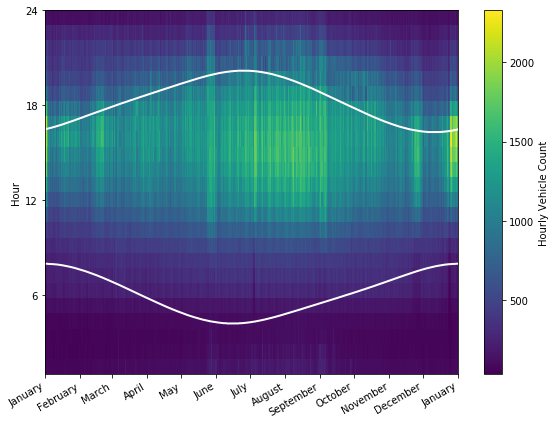

In [4]:
# Look at hourly count for each day of the year

# Get data grouped by DOY from site, only looking at Westbound right now
road_site_date = road_count[(road_count['TravelDirection'] == 'Westbound') &\
        (road_count['SiteId'] == 'S901')].groupby(['DOY'])

# Get average count for each hour and doy
doys, hours_count = np.zeros([365,]), np.zeros([24,366])
hours_count[:,:] = np.float('NaN')
for name, group in road_site_date:
    doy = name
    for i in range(0,24):
        hours_count[i,doy-1] = group['Hour'+str(i+1)].mean()

        
# Make plot
fig = plt.figure(figsize=(8,6))
ax=plt.gca()
date1 = dt.datetime(2013,1,1)
date2 = dt.datetime(2013,12,31)
plt.imshow(hours_count[:,:],extent=[mdates.date2num(date1),mdates.date2num(date2),1,24],\
    origin='lower',aspect='auto')
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
fig.autofmt_xdate()
ax.set_yticks(range(6,26,6))
ax.set_ylabel('Hour')
cbar = plt.colorbar()
cbar.set_label('Hourly Vehicle Count')

# Get average sunset and sunrise time for each day
sun_doy = sun.groupby('DOY')
means = sun_doy.mean()
plt.plot(np.arange(mdates.date2num(date1),mdates.date2num(date2)+2),sun_doy.mean()['SunsetHour'],'w',lw=2)
plt.plot(np.arange(mdates.date2num(date1),mdates.date2num(date2)+2),sun_doy.mean()['SunriseHour'],'w',lw=2)

fig.tight_layout()

# The distribution changes throughout the year; during the summer, there are more
# vehicles traveling across the pass over a greater portion of the day. White
# lines show sunrise and sunset times.

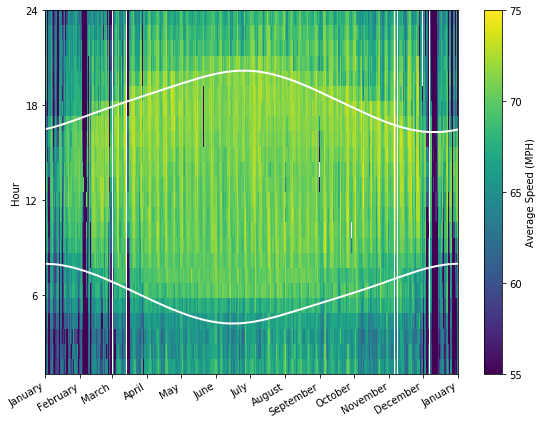

In [5]:
# Look at average speed for each hour and day of the year

# Get average speed grouped by Hour and DOY, only looking at Westbound right now
road_site_date = road_speed[(road_speed['TravelDirection'] == 'Westbound') &\
        (road_speed['SiteId'] == 'S901')].groupby(['DOY','Hour'])

doys, hours_speed = np.zeros([365,]), np.zeros([24,366])
hours_speed[:,:] = np.float('NaN')
for name, group in road_site_date:
    doy, hour = name
    hours_speed[hour-1,doy-1] = group['AverageMPH'].mean()

fig = plt.figure(figsize=(8,6))
ax=plt.gca()
date1 = dt.datetime(2013,1,1)
date2 = dt.datetime(2013,12,31)
plt.imshow(hours_speed,extent=[mdates.date2num(date1),mdates.date2num(date2),1,24],\
    origin='lower',aspect='auto',vmin=55,vmax=75)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
fig.autofmt_xdate()
ax.set_yticks(range(6,26,6))
ax.set_ylabel('Hour')
cbar = plt.colorbar()
cbar.set_ticks(range(55,80,5))
cbar.set_label('Average Speed (MPH)')

# Get average sunset and sunrise time for each day
sun_doy = sun.groupby('DOY')
means = sun_doy.mean()
plt.plot(np.arange(mdates.date2num(date1),mdates.date2num(date2)+2),sun_doy.mean()['SunsetHour'],'w',lw=2)
plt.plot(np.arange(mdates.date2num(date1),mdates.date2num(date2)+2),sun_doy.mean()['SunriseHour'],'w',lw=2)

fig.tight_layout()

# It looks like vehicles travel faster during the summer over a greater 
# portion of the day. It would be interesting to see how this compares to
# daylight hours. In fact, vehicles travel faster when it is 
# light outside. White lines show sunrise and sunset times; if we 
# consider that daylight lasts an hour after sunset (add an hour
# to the sunset time), the agreement is striking.

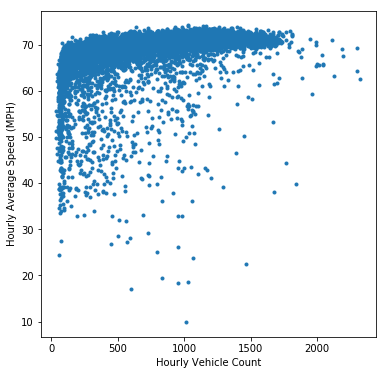

In [6]:
# That's interesting. At first glance, it appears there are more vehicles 
# going over Snoqualmie Pass in the summer, but on average the vehicles 
# are moving faster, perhaps because the road conditions are "better" 
# (its light out and there is less precipitation). 

# How does it look if we actually plot average hourly speed vs. average hourly 
# vehicle count?

plt.figure(figsize=(6,6))
plt.plot(hours_count.flatten(),hours_speed.flatten(),'.')
plt.xlabel('Hourly Vehicle Count');
plt.ylabel('Hourly Average Speed (MPH)');

# This relationship definitely requires further investigation. Is it the same for 
# the other mountain passes? What if we don't bin by day of year first and instead
# bin by weekday?